# Resnet + Transfer Learning
 
Notebook para testar o uso da VGG para uma nova aplicação, através do uso de Transfer Learning.

Iremos usar o tensorflow e keras

será usado o problema de classificação de imagens de frutas

In [2]:
from keras.layers import Input, Lambda, Dense, Flatten
from keras.models import Model
from keras.applications.resnet import ResNet50, preprocess_input
# from keras.applications.inception_v3 import InceptionV3, preprocess_input
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import load_img, img_to_array


from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt

from glob import glob

#### variaveis uteis

In [1]:

IMAGE_SIZE = [100, 100] # feel free to change depending on dataset

In [3]:
# training config:
epochs = 16
batch_size = 32

#### dataset

In [5]:
# para funcionar no colab 
!wget -nc https://lazyprogrammer.me/course_files/fruits-360.zip

--2023-03-16 17:41:13--  https://lazyprogrammer.me/course_files/fruits-360.zip
Resolving lazyprogrammer.me (lazyprogrammer.me)... 172.67.213.166, 104.21.23.210, 2606:4700:3031::6815:17d2, ...
Connecting to lazyprogrammer.me (lazyprogrammer.me)|172.67.213.166|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 190820824 (182M) [application/zip]
Saving to: ‘fruits-360.zip’

fruits-360.zip      100%[===================>] 181.98M   314KB/s    in 11m 59s 

2023-03-16 17:53:13 (259 KB/s) - ‘fruits-360.zip’ saved [190820824/190820824]



In [6]:
# colab tb
!unzip -nq fruits-360.zip

In [7]:
train_path = 'fruits-360/Training/'
valid_path = 'fruits-360/Validation/'

In [8]:
# numero de arquivos
image_files = glob(train_path + '/*/*.jp*g')
valid_image_files = glob(valid_path + '/*/*.jp*g')

In [9]:
print(len(image_files), len(valid_image_files))

28736 9673


In [10]:
# numero de classes
folders = glob(train_path + '/*')

print(len(folders))

60


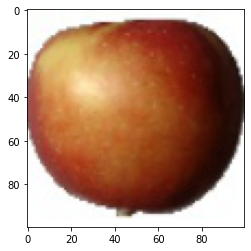

In [11]:
# verificando uma imagem
plt.imshow(load_img(np.random.choice(image_files)))
plt.show()

### Model

In [12]:
# removando a ultima camada da rede para realizarmos o treinamento posterior
res = ResNet50(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

94765736/94765736 [==============================] - 1s 0us/step


In [13]:
# congelando os pesos para não serem treinados
for layer in res.layers:
  layer.trainable = False


In [14]:
# nova camada sendo adicionada com o numero de saidas igual ao numero de classes
x = Flatten()(res.output)
# x = Dense(1000, activation='relu')(x)
prediction = Dense(len(folders), activation='softmax')(x)

In [15]:
# juntando tudo em um objeto model
model = Model(inputs=res.input, outputs=prediction)

In [16]:
# visualizando estrutura da rede
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 106, 106, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 50, 50, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 50, 50, 64)   256         ['conv1_conv[0][0]']         

In [17]:
# definido função de custo e otimizador
model.compile(
  loss='sparse_categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)

In [18]:
# criar instancia do ImageDataGenerator
gen = ImageDataGenerator(
  rotation_range=20,
  width_shift_range=0.1,
  height_shift_range=0.1,
  shear_range=0.1,
  zoom_range=0.2,
  horizontal_flip=True,
  vertical_flip=True,
  preprocessing_function=preprocess_input
)

In [19]:
val_gen = ImageDataGenerator( preprocessing_function=preprocess_input)

In [20]:
# get label mapping for confusion matrix plot later
test_gen = gen.flow_from_directory(valid_path, target_size=IMAGE_SIZE)
print(test_gen.class_indices)
labels = [None] * len(test_gen.class_indices)
for k, v in test_gen.class_indices.items():
  labels[v] = k

Found 9673 images belonging to 60 classes.
{'Apple Braeburn': 0, 'Apple Golden 1': 1, 'Apple Golden 2': 2, 'Apple Golden 3': 3, 'Apple Granny Smith': 4, 'Apple Red 1': 5, 'Apple Red 2': 6, 'Apple Red 3': 7, 'Apple Red Delicious': 8, 'Apple Red Yellow': 9, 'Apricot': 10, 'Avocado': 11, 'Avocado ripe': 12, 'Banana': 13, 'Banana Red': 14, 'Cactus fruit': 15, 'Carambula': 16, 'Cherry': 17, 'Clementine': 18, 'Cocos': 19, 'Dates': 20, 'Granadilla': 21, 'Grape Pink': 22, 'Grape White': 23, 'Grape White 2': 24, 'Grapefruit Pink': 25, 'Grapefruit White': 26, 'Guava': 27, 'Huckleberry': 28, 'Kaki': 29, 'Kiwi': 30, 'Kumquats': 31, 'Lemon': 32, 'Lemon Meyer': 33, 'Limes': 34, 'Litchi': 35, 'Mandarine': 36, 'Mango': 37, 'Maracuja': 38, 'Nectarine': 39, 'Orange': 40, 'Papaya': 41, 'Passion Fruit': 42, 'Peach': 43, 'Peach Flat': 44, 'Pear': 45, 'Pear Abate': 46, 'Pear Monster': 47, 'Pear Williams': 48, 'Pepino': 49, 'Pineapple': 50, 'Pitahaya Red': 51, 'Plum': 52, 'Pomegranate': 53, 'Quince': 54, 'Ra

min: -68.03677 max: 151.061


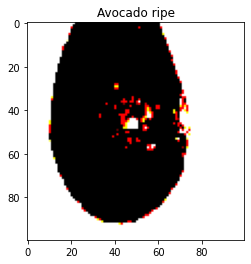

In [21]:
# vissualizar uma amostra
for x, y in test_gen:
  print("min:", x[0].min(), "max:", x[0].max())
  plt.title(labels[np.argmax(y[0])])
  plt.imshow(x[0])
  plt.show()
  break


In [22]:
# create generators
train_generator = gen.flow_from_directory(
  train_path,
  target_size=IMAGE_SIZE,
  shuffle=True,
  batch_size=batch_size,
  class_mode='sparse'
)
valid_generator = val_gen.flow_from_directory(
  valid_path,
  target_size=IMAGE_SIZE,
  shuffle=True,
  batch_size=batch_size,
  class_mode='sparse'
)

Found 28736 images belonging to 60 classes.
Found 9673 images belonging to 60 classes.


 - treinamento

In [23]:
# fit the model
r = model.fit(
  train_generator,
  validation_data=valid_generator,
  epochs=epochs,
  steps_per_epoch=len(image_files) // batch_size,
  validation_steps=len(valid_image_files) // batch_size,
)

Epoch 1/16
898/898 [==============================] - 119s 121ms/step - loss: 0.9367 - accuracy: 0.9138 - val_loss: 0.9133 - val_accuracy: 0.9368
Epoch 2/16
898/898 [==============================] - 118s 131ms/step - loss: 0.3539 - accuracy: 0.9739 - val_loss: 0.9652 - val_accuracy: 0.9594
Epoch 3/16
898/898 [==============================] - 107s 120ms/step - loss: 0.3671 - accuracy: 0.9786 - val_loss: 0.3640 - val_accuracy: 0.9774
Epoch 4/16
898/898 [==============================] - 107s 119ms/step - loss: 0.3029 - accuracy: 0.9832 - val_loss: 0.6499 - val_accuracy: 0.9782
Epoch 5/16
898/898 [==============================] - 118s 132ms/step - loss: 0.2562 - accuracy: 0.9869 - val_loss: 0.1217 - val_accuracy: 0.9889
Epoch 6/16
898/898 [==============================] - 107s 119ms/step - loss: 0.2607 - accuracy: 0.9888 - val_loss: 0.2614 - val_accuracy: 0.9883
Epoch 7/16
898/898 [==============================] - 107s 119ms/step - loss: 0.2092 - accuracy: 0.9908 - val_loss: 0.8130 -

In [24]:
def get_confusion_matrix(data_path, N):
  # we need to see the data in the same order
  # for both predictions and targets
  print("Generating confusion matrix", N)
  predictions = []
  targets = []
  i = 0
  for x, y in gen.flow_from_directory(data_path, target_size=IMAGE_SIZE, shuffle=False, batch_size=batch_size * 2):
    i += 1
    if i % 50 == 0:
      print(i)
    p = model.predict(x)
    p = np.argmax(p, axis=1)
    y = np.argmax(y, axis=1)
    predictions = np.concatenate((predictions, p))
    targets = np.concatenate((targets, y))
    if len(targets) >= N:
      break

  cm = confusion_matrix(targets, predictions)
  return cm

In [25]:
cm = get_confusion_matrix(train_path, len(image_files))
print(cm)
valid_cm = get_confusion_matrix(valid_path, len(valid_image_files))
print(valid_cm)

Generating confusion matrix 28736
Found 28736 images belonging to 60 classes.
2/2 [==============================] - 0s 38ms/step
50
2/2 [==============================] - 0s 37ms/step
100
2/2 [==============================] - 0s 38ms/step
150
2/2 [==============================] - 0s 37ms/step
200
2/2 [==============================] - 0s 41ms/step
250
2/2 [==============================] - 0s 37ms/step
300
2/2 [==============================] - 0s 37ms/step
350
2/2 [==============================] - 0s 42ms/step
400
2/2 [==============================] - 0s 37ms/step
[[491   0   0 ...   0   0   0]
 [  0 492   0 ...   0   0   0]
 [  0   0 438 ...   0   0   0]
 ...
 [  0   0   0 ... 491   0   0]
 [  0   0   0 ...   0 490   0]
 [  0   0   0 ...   0   0 490]]
Generating confusion matrix 9673
Found 9673 images belonging to 60 classes.
2/2 [==============================] - 0s 41ms/step
50
2/2 [==============================] - 0s 37ms/step
100
2/2 [==============================] - 0s 37

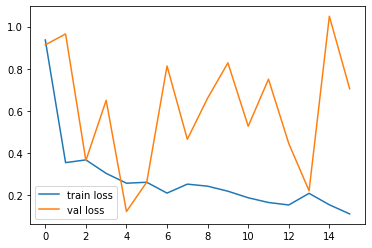

In [26]:
# loss
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend()
plt.show()


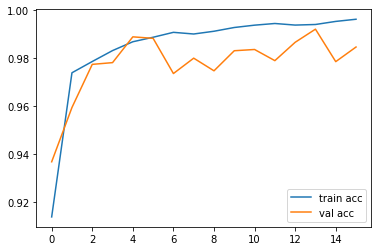

In [27]:
plt.plot(r.history['accuracy'], label='train acc')
plt.plot(r.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()